## 1. Important Libraries

In [26]:
import torch
from torch import nn,optim
import torchvision
from torchvision import datasets, transforms, models

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,precision_recall_fscore_support 

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 
import pandas as pd
import os
import random
import itertools

from torchinfo import summary
import seaborn as sns
from torch_lr_finder import LRFinder

from Dataset import covid_dataset
from Visualizations import plot_samples,plot_samples_with_predictions,plot_confusion
from TransferModel import Model
from Main import main,Test_ensemble,Get_predictions

## 2. Constants and Parameters

In [21]:
data_dir='./datasets/TwoClasses_data'
num_classes=2
epochs=40
batch_size=64
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 3. Covid Dataset

### 3.1 Creating Train/Test Splits and DataLoaders without any data preprocessing or Transformations

In [84]:
Train_set ,Test_set ,Trainloader_, Testloader_= covid_dataset(data_dir,batch_size=batch_size,Transformation=False)

### 3.2 Exploring Dataset 

In [4]:
print("Train set:",len(Train_set))
print("Test set:",len(Test_set))

Train set: 1200
Test set: 508


#### 3.2.1 **Classes**

In [5]:
print(f"Dataset Classes: {Train_set.classes}")
print(f"Dataset Label: {Train_set.class_to_idx}")

Dataset Classes: ['COVID', 'PNEUMONIA']
Dataset Label: {'COVID': 0, 'PNEUMONIA': 1}


##### Classes Distribution

In [6]:
train_samplesize = pd.DataFrame.from_dict(
    {'PNEUMONIA': [len( [os.path.join(data_dir+'/train/NORMAL', filename) 
                     for filename in os.listdir(data_dir+'/train/PNEUMONIA')] )], 
     'COVID': [len([os.path.join(data_dir+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(data_dir+'/train/COVID')])] }
)
train_samplesize


,PNEUMONIA,COVID
0,700,500


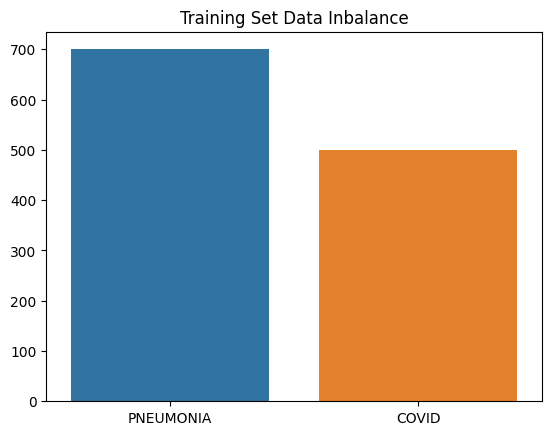

In [7]:
sns.barplot(data=train_samplesize).set_title('Training Set Data Inbalance')
plt.show()

#### 3.2.2 Input Tensor Information

**A sample of trainset is a tuple consists of image and class**

In [8]:
img,lbl=Train_set[0]

print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype} \n")
print(f"Image label: {lbl} : {lbl}")
print(f"Label datatype: {type(lbl)}")

Image shape: torch.Size([3, 361, 373])
Image datatype: torch.float32 

Image label: 0 : 0
Label datatype: <class 'int'>


 #### **3.2.3 Plotting random Samples with labels**

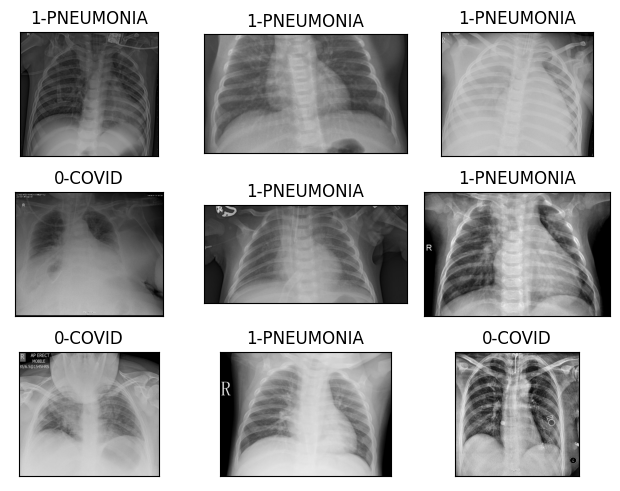

In [85]:
plot_samples(Train_set)

### 3.3 **Dataset with transformation**

In [3]:
Train_set_Aug ,Test_set_Aug ,Trainloader, Testloader= covid_dataset(data_dir,batch_size=batch_size,Transformation=True)


In [12]:
img,lbl=Train_set_Aug[0]

print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype} \n")
print(f"Image label: {lbl} : {lbl}")
print(f"Label datatype: {type(lbl)}")

Image shape: torch.Size([3, 224, 224])
Image datatype: torch.float32 

Image label: 0 : 0
Label datatype: <class 'int'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


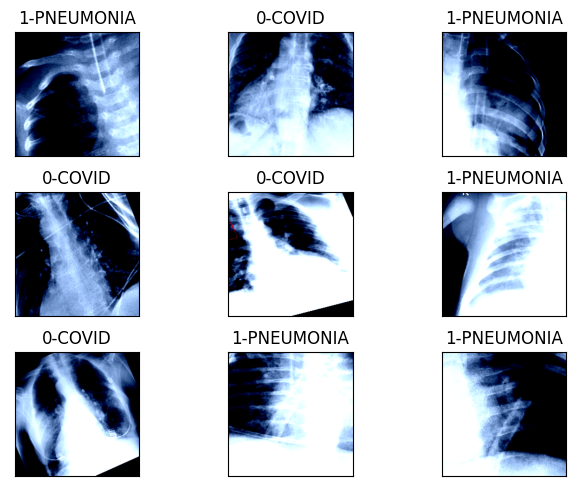

In [82]:
plot_samples(Train_set_Aug)

In [14]:
print(f"Total no. of batches in trainloader : {len(Trainloader)}")
print(f"Total no. of batches in testloader : {len(Testloader)}")

Total no. of batches in trainloader : 10
Total no. of batches in testloader : 4


## 4. Model

#### **Some Model Architectures:**
`Resnet18`
`Mobilenet_v2`
`Shufflenet_v2`

In [4]:
models_arch=['resnet18','mobilenet_v2',"shufflenet_v2_x2_0"]

In [5]:
models={}
for model in models_arch:
    # Create Instances of Our Models
    models[model]=Model(model,num_classes=num_classes,device=device)
    
keys=list(models.keys())
keys

Using cache found in /home1/ece1/.cache/torch/hub/pytorch_vision_main
Using cache found in /home1/ece1/.cache/torch/hub/pytorch_vision_main
Using cache found in /home1/ece1/.cache/torch/hub/pytorch_vision_main


['resnet18', 'mobilenet_v2', 'shufflenet_v2_x2_0']

In [17]:
summary(models['resnet18'], 
        (128,3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
Model (Model)                                 [128, 3, 224, 224]   [128, 2]             --                   Partial
├─ResNet (model)                              [128, 3, 224, 224]   [128, 2]             --                   Partial
│    └─Conv2d (conv1)                         [128, 3, 224, 224]   [128, 64, 112, 112]  (9,408)              False
│    └─BatchNorm2d (bn1)                      [128, 64, 112, 112]  [128, 64, 112, 112]  (128)                False
│    └─ReLU (relu)                            [128, 64, 112, 112]  [128, 64, 112, 112]  --                   --
│    └─MaxPool2d (maxpool)                    [128, 64, 112, 112]  [128, 64, 56, 56]    --                   --
│    └─Sequential (layer1)                    [128, 64, 56, 56]    [128, 64, 56, 56]    --                   False
│    │    └─BasicBlock (0)                    [128, 64, 56, 56]    [128, 64, 5

## 5. Loss Function and Optimizers

In [6]:
loss_fn = nn.CrossEntropyLoss()

def Get_optimizer(model,opt="SGD",lr=3e-3):
    if opt=="SGD":
        return  optim.SGD(model.parameters(), lr=lr)
    elif opt=="Adam":
        return optim.Adam(model.parameters(), lr=lr)
    elif opt=="RMSprop":
        return optim.RMSprop(model.parameters(), lr=lr)

## 6. LR_Finder

In [7]:
def Get_LR(Trainloader,model,optimizer,loss_fn,device="cuda"):
    lr_finder = LRFinder(model, optimizer, loss_fn, device=device)
    lr_finder.range_test(Trainloader, end_lr=100, num_iter=100)
    lr_finder.plot() 
    lr_finder.reset()

## 8. Training and Testing

### 8.1 `Resnet18`

In [13]:
lr=1e-3
model1=models[keys[0]]
optimizer1=Get_optimizer(model1,opt="RMSprop",lr=lr)

In [14]:
main(model1,Trainloader,Testloader,loss_fn,
     optimizer1,lr=lr,name=keys[0],epochs=20,save_weights=True,scheduler_bol=True)

Ep[Train]1/20: 100%|█| 19/19 [00:24<00:00,  1.30s/it, loss=0.675121, acc=0.70751
Ep[Train]2/20: 100%|█| 19/19 [00:24<00:00,  1.30s/it, loss=0.415054, acc=0.84566
Ep[Train]3/20: 100%|█| 19/19 [00:24<00:00,  1.30s/it, loss=0.279906, acc=0.92927
Ep[Train]4/20: 100%|█| 19/19 [00:24<00:00,  1.28s/it, loss=0.220139, acc=0.93092
Ep[Train]5/20: 100%|█| 19/19 [00:23<00:00,  1.25s/it, loss=0.210157, acc=0.92818
Ep[Train]6/20: 100%|█| 19/19 [00:23<00:00,  1.26s/it, loss=0.203962, acc=0.92023
Ep[Train]7/20: 100%|█| 19/19 [00:23<00:00,  1.26s/it, loss=0.164233, acc=0.95257
Ep[Train]8/20: 100%|█| 19/19 [00:23<00:00,  1.25s/it, loss=0.189350, acc=0.93064
Ep[Train]9/20: 100%|█| 19/19 [00:23<00:00,  1.25s/it, loss=0.175658, acc=0.94380
Ep[Train]10/20: 100%|█| 19/19 [00:23<00:00,  1.24s/it, loss=0.181293, acc=0.9438
Ep[Train]11/20: 100%|█| 19/19 [00:23<00:00,  1.24s/it, loss=0.190671, acc=0.9331
Ep[Train]12/20: 100%|█| 19/19 [00:23<00:00,  1.24s/it, loss=0.162458, acc=0.9495
Ep[Train]13/20: 100%|█| 19/1

### 8.2 `Mobilenet_v2`

In [15]:
model2=models[keys[1]]
optimizer2=Get_optimizer(model2,opt="RMSprop",lr=lr)

In [16]:
main(model2,Trainloader,Testloader,loss_fn,
     optimizer2,lr=lr,name=keys[1],epochs=20,save_weights=True,scheduler_bol=True)

Ep[Train]1/20: 100%|█| 19/19 [00:23<00:00,  1.25s/it, loss=1.172792, acc=0.67571
Ep[Train]2/20: 100%|█| 19/19 [00:23<00:00,  1.25s/it, loss=0.332685, acc=0.87171
Ep[Train]3/20: 100%|█| 19/19 [00:23<00:00,  1.23s/it, loss=0.239039, acc=0.90460
Ep[Train]4/20: 100%|█| 19/19 [00:23<00:00,  1.23s/it, loss=0.199893, acc=0.92653
Ep[Train]5/20: 100%|█| 19/19 [00:23<00:00,  1.22s/it, loss=0.221993, acc=0.91447
Ep[Train]6/20: 100%|█| 19/19 [00:23<00:00,  1.22s/it, loss=0.148391, acc=0.95504
Ep[Train]7/20: 100%|█| 19/19 [00:23<00:00,  1.22s/it, loss=0.151746, acc=0.94682
Ep[Train]8/20: 100%|█| 19/19 [00:23<00:00,  1.23s/it, loss=0.149214, acc=0.95038
Ep[Train]9/20: 100%|█| 19/19 [00:23<00:00,  1.24s/it, loss=0.139915, acc=0.95641
Ep[Train]10/20: 100%|█| 19/19 [00:23<00:00,  1.23s/it, loss=0.162022, acc=0.9418
Ep[Train]11/20: 100%|█| 19/19 [00:23<00:00,  1.22s/it, loss=0.162575, acc=0.9410
Ep[Train]12/20: 100%|█| 19/19 [00:23<00:00,  1.23s/it, loss=0.140263, acc=0.9577
Ep[Train]13/20: 100%|█| 19/1

### 8.3 `shufflenet_v2`

In [17]:
model3=models[keys[2]]
optimizer3=Get_optimizer(model3,opt="RMSprop",lr=lr)

In [18]:
main(model3,Trainloader,Testloader,loss_fn,
     optimizer=Get_optimizer(model3,opt="RMSprop",lr=lr),lr=lr,name=keys[2],scheduler_bol=True,epochs=20,save_weights=True)

Ep[Train]1/20: 100%|█| 19/19 [00:23<00:00,  1.21s/it, loss=0.652496, acc=0.77330
Ep[Train]2/20: 100%|█| 19/19 [00:23<00:00,  1.21s/it, loss=0.188971, acc=0.93229
Ep[Train]3/20: 100%|█| 19/19 [00:23<00:00,  1.21s/it, loss=0.106981, acc=0.96683
Ep[Train]4/20: 100%|█| 19/19 [00:23<00:00,  1.21s/it, loss=0.133288, acc=0.95257
Ep[Train]5/20: 100%|█| 19/19 [00:22<00:00,  1.20s/it, loss=0.085227, acc=0.97258
Ep[Train]6/20: 100%|█| 19/19 [00:22<00:00,  1.20s/it, loss=0.086149, acc=0.97505
Ep[Train]7/20: 100%|█| 19/19 [00:22<00:00,  1.20s/it, loss=0.088909, acc=0.96381
Ep[Train]8/20: 100%|█| 19/19 [00:22<00:00,  1.20s/it, loss=0.076561, acc=0.97615
Ep[Train]9/20: 100%|█| 19/19 [00:22<00:00,  1.20s/it, loss=0.078133, acc=0.97779
Ep[Train]10/20: 100%|█| 19/19 [00:22<00:00,  1.21s/it, loss=0.088183, acc=0.9682
Ep[Train]11/20: 100%|█| 19/19 [00:22<00:00,  1.21s/it, loss=0.081474, acc=0.9758
Ep[Train]12/20: 100%|█| 19/19 [00:22<00:00,  1.20s/it, loss=0.079738, acc=0.9695
Ep[Train]13/20: 100%|█| 19/1

## 9. Models Ensambling

### 9.1 Resnet + Mobilenet

In [40]:
Test_loss , Test_acc,lbl_ensemble1,pred_ensemble1= Test_ensemble(model1,model2, Testloader, loss_fn,device='cuda')

Epoch[Test]1/1: 100%|█| 8/8 [00:08<00:00,  1.08s/it, loss=0.027612, acc=0.992188


### 9.2 Resnet + Shufflenet

In [41]:
Test_loss , Test_acc,lbl_ensemble2,pred_ensemble2= Test_ensemble(model1,model3, Testloader, loss_fn)

Epoch[Test]1/1: 100%|█| 8/8 [00:08<00:00,  1.07s/it, loss=0.024501, acc=0.994141


### 9.3 Mobilenet + Shufflenet

In [42]:
Test_loss , Test_acc,lbl_ensemble3,pred_ensemble3= Test_ensemble(model2,model3, Testloader, loss_fn)

Epoch[Test]1/1: 100%|█| 8/8 [00:08<00:00,  1.07s/it, loss=0.024901, acc=0.998047


#### Ensemble 3 has highest accuracy `99.8` with least error

## 10. Output Visualization for Best Model `(Ensemble 3)`

### 10.1 Confusion Matrix

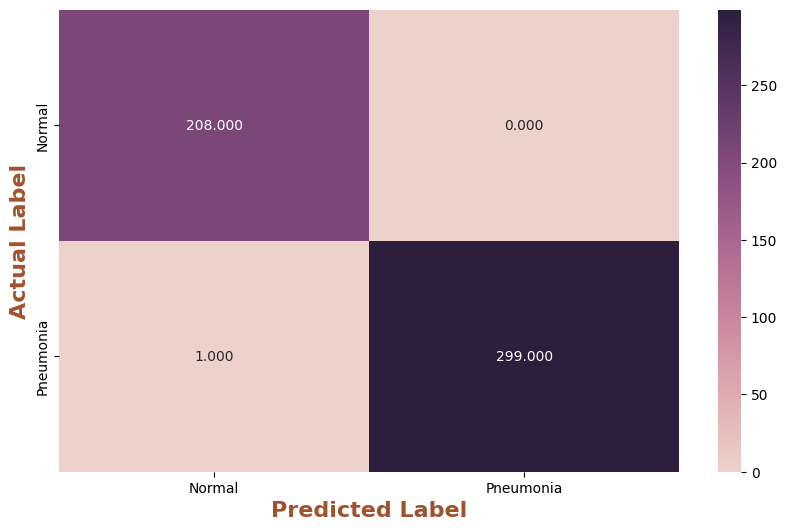

In [50]:
plot_confusion(lbl_ensemble3,pred_ensemble3,"2class_conf_noNorm",num_classes=2,Normalize=False)

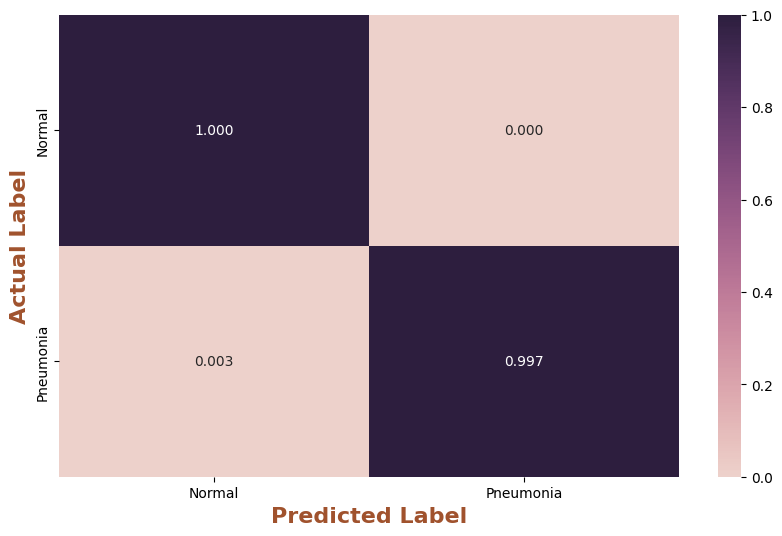

In [51]:
plot_confusion(lbl_ensemble3,pred_ensemble3,"2class_conf_Norm",num_classes=2,Normalize=True)

### 10.2 Classification Metrics

In [52]:
Report=classification_report(lbl_ensemble3,pred_ensemble3,digits=4)
print(Report)

              precision    recall  f1-score   support

           0     0.9952    1.0000    0.9976       208
           1     1.0000    0.9967    0.9983       300

    accuracy                         0.9980       508
   macro avg     0.9976    0.9983    0.9980       508
weighted avg     0.9980    0.9980    0.9980       508



### 10.3 Plot Prediction VS Actual Labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


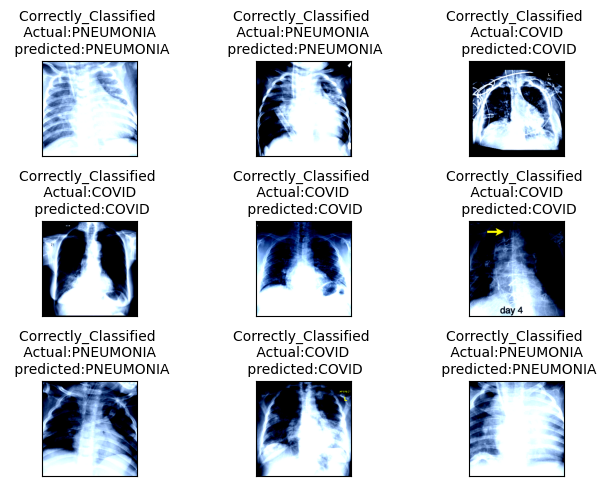

In [78]:
plot_samples(Test_set_Aug,preds=pred_ensemble3)

### 10.4 Plot Missclassified Samples

367


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


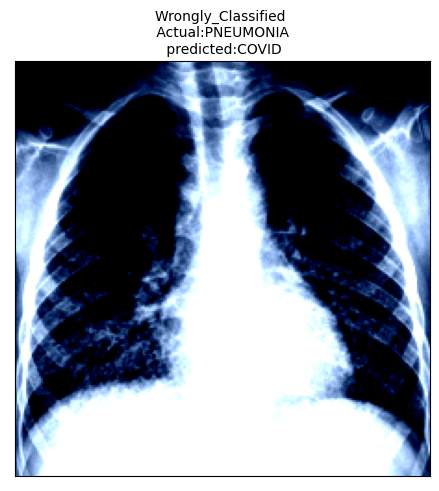

In [72]:
def plot_misclassified(split_set,preds):

    idx_to_class = {split_set.class_to_idx[k]: k for k in split_set.class_to_idx}
    misclassified=[]
    #figure, ax = plt.subplots(3, 3,constrained_layout = True)

    for idx in range(len(split_set)):
        if split_set[idx][1]!=preds[idx]:
            check="Wrongly_Classified"
            print (idx)
            misclassified.append (idx)
    
    figure, ax = plt.subplots(len(misclassified) ,constrained_layout = True)
    
    for i,idx  in enumerate (misclassified):
        ax.imshow(split_set[idx][0].permute(1,2,0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f"{check} \n Actual:{idx_to_class[split_set[idx][1]]} \n predicted:{idx_to_class[preds[idx]]}"
                       , fontsize=10)
        
plot_misclassified(Test_set_Aug,preds=pred_ensemble3)